In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import spacy
from tqdm import tqdm 
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("data_2/train.csv")

In [3]:
df.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [4]:
df['class'].value_counts()

class
1    92063
0    89404
Name: count, dtype: int64

In [5]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['class'], random_state=42)

In [6]:
df_test['class'].value_counts()

class
1    27619
0    26822
Name: count, dtype: int64

In [7]:
sw = set(get_stop_words("english"))
puncts = set(punctuation)
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

def preprocess_text(txt):
  txt = str(txt)
  txt = "".join(c for c in txt if c not in puncts)
  txt = txt.lower()
  txt = re.sub("not\s", "not", txt)
  txt = re.sub("dont\s", "dont", txt)
  txt = re.sub("doesnt\s", "doesnt", txt)
  txt = re.sub("didnt\s", "didnt", txt)
  txt = re.sub("havent\s", "havent", txt)
  txt = re.sub("hasnt\s", "hasnt", txt)
  txt = nlp(txt)
  txt = [word.lemma_ for word in txt if word not in sw]
  return " ".join(txt)

In [8]:
df_train['text'].iloc[:1].values

array(['парик Недзуми покупают. эх, жалко(( но щито поделать..'],
      dtype=object)

In [9]:
df_train['text'].iloc[:1].apply(preprocess_text).values

array(['парик недзуми покупают эх жалко но щито поделать'], dtype=object)

In [10]:
df_train['text'] = df_train['text'].progress_apply(preprocess_text)
df_test['text'] = df_test['text'].progress_apply(preprocess_text)

  0%|          | 0/127026 [00:00<?, ?it/s]

100%|██████████| 54441/54441 [05:12<00:00, 174.26it/s]


In [11]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [12]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

Инициализируем сеть LSTM:

In [13]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [14]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [15]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [16]:
def get_loaders(max_words=2000, max_len=20):

  tokens = word_tokenize(train_corpus)
  tokens_filtered = [word for word in tokens if word.isalnum()]
  dist = FreqDist(tokens_filtered)
  tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
  vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
  
  x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["text"]])
  x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["text"]])

  train_dataset = DataWrapper(x_train, df_train['class'].values)
  train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

  test_dataset = DataWrapper(x_test, df_test['class'].values)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
  return train_loader, test_loader

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
def learn_net(model, epochs=20, th=0.5):
  model = model.to(device)
  model.train()
  
  train_loss_history = []
  test_loss_history = []
  train_f1_history = []
  test_f1_history = []

  for epoch in range(epochs):  
      running_loss, test_loss = 0.0, 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_train, f1_score_test = 0.0, 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          
          # обнуляем градиент
          optimizer.zero_grad()
          outputs = model(inputs)
          
          loss = criterion(outputs, labels.float().view(-1, 1))
          loss.backward()
          optimizer.step()

          # подсчет ошибки на обучении
          running_loss += loss.item()
          # подсчет метрики на обучении
          pred_labels = torch.squeeze((outputs > th).int())
          tp_train += ((labels == pred_labels) & (labels == 1)).sum().item()
          tn_train += ((labels == pred_labels) & (labels == 0)).sum().item()
          fp_train += ((labels != pred_labels) & (labels == 0)).sum().item()
          fn_train += ((labels != pred_labels) & (labels == 1)).sum().item()
          
      # выводим статистику о процессе обучения
      model.eval()
      pr_train = tp_train / (tp_train + fp_train + .001)
      rec_train = tp_train / (tp_train + fn_train + .001)
      f1_score_train = 2 * pr_train * rec_train / (pr_train + rec_train + .001)
      print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Loss: {running_loss/(i+1):.3f}. ' \
              f'F1: {f1_score_train:.3f}', end='. ')
      
      train_loss_history.append(running_loss/(i+1))
      train_f1_history.append(f1_score_train)
      running_loss = 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      f1_score_train = 0.0

          # выводим статистику на тестовых данных
      for j, data in enumerate(test_loader):
          test_labels = data[1].to(device)
          test_outputs = model(data[0].to(device))
          
          # подсчет ошибки на тесте
          test_loss += criterion(test_outputs, test_labels.float().view(-1, 1))
          # подсчет метрики на тесте
          pred_test_labels = torch.squeeze((test_outputs > th).int())
          tp_test += ((test_labels == pred_test_labels) & (test_labels == 1)).sum().item()
          tn_test += ((test_labels == pred_test_labels) & (test_labels == 0)).sum().item()
          fp_test += ((test_labels != pred_test_labels) & (test_labels == 0)).sum().item()
          fn_test += ((test_labels != pred_test_labels) & (test_labels == 1)).sum().item()
      
      pr_test = tp_test / (tp_test + fp_test + .001)
      rec_test = tp_test / (tp_test + fn_test + .001)
      f1_score_test = 2 * pr_test * rec_test / (pr_test + rec_test + .001)
      test_loss_history.append(test_loss.item()/(j+1))
      test_f1_history.append(f1_score_test)
      print(f'Test loss: {test_loss/(j+1):.3f}. Test F1: {f1_score_test:.3f}')
      test_loss = 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_test = 0.0

      model.train()
          
  print('Training is finished!')
  return train_loss_history, test_loss_history, train_f1_history, test_f1_history

In [19]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [5, 10, 15, 20]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=i)
  model = GRUFixedLen(vocab_size=2000)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [249/249]. Loss: 0.597. F1: 0.667. Test loss: 0.567. Test F1: 0.696
Epoch [2/20]. Step [249/249]. Loss: 0.559. F1: 0.705. Test loss: 0.563. Test F1: 0.691
Epoch [3/20]. Step [249/249]. Loss: 0.548. F1: 0.714. Test loss: 0.563. Test F1: 0.700
Epoch [4/20]. Step [249/249]. Loss: 0.542. F1: 0.720. Test loss: 0.564. Test F1: 0.707
Epoch [5/20]. Step [249/249]. Loss: 0.539. F1: 0.722. Test loss: 0.566. Test F1: 0.702
Epoch [6/20]. Step [249/249]. Loss: 0.536. F1: 0.725. Test loss: 0.572. Test F1: 0.687
Epoch [7/20]. Step [249/249]. Loss: 0.534. F1: 0.726. Test loss: 0.570. Test F1: 0.695
Epoch [8/20]. Step [249/249]. Loss: 0.533. F1: 0.725. Test loss: 0.566. Test F1: 0.709
Epoch [9/20]. Step [249/249]. Loss: 0.533. F1: 0.726. Test loss: 0.572. Test F1: 0.695
Epoch [10/20]. Step [249/249]. Loss: 0.533. F1: 0.725. Test loss: 0.573. Test F1: 0.706
Epoch [11/20]. Step [249/249]. Loss: 0.534. F1: 0.726. Test loss: 0.569. Test F1: 0.704
Epoch [12/20]. Step [249/249]. Loss: 0.53

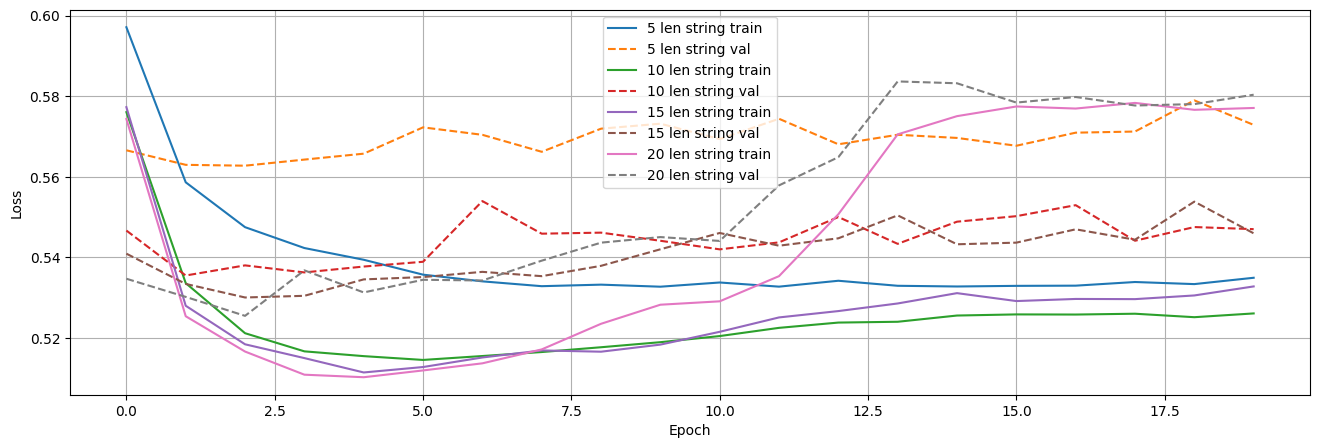

In [20]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(losses_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(losses_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

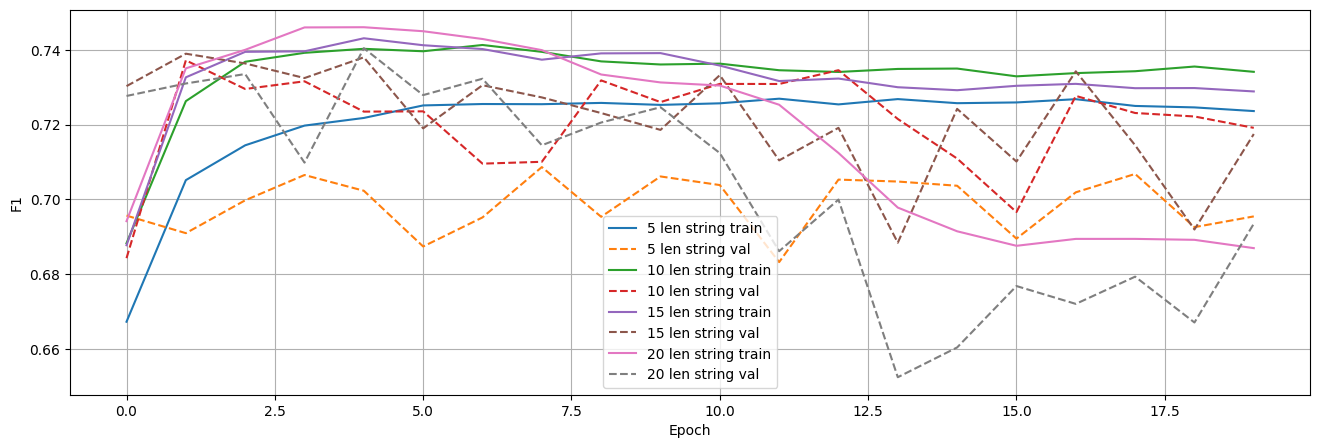

In [21]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(f1_list_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(f1_list_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

In [24]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=20)
  model = LSTMFixedLen(vocab_size=2000, use_last=i)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [249/249]. Loss: 0.600. F1: 0.674. Test loss: 0.545. Test F1: 0.710
Epoch [2/20]. Step [249/249]. Loss: 0.531. F1: 0.730. Test loss: 0.529. Test F1: 0.720
Epoch [3/20]. Step [249/249]. Loss: 0.513. F1: 0.742. Test loss: 0.525. Test F1: 0.734
Epoch [4/20]. Step [249/249]. Loss: 0.502. F1: 0.751. Test loss: 0.527. Test F1: 0.726
Epoch [5/20]. Step [249/249]. Loss: 0.491. F1: 0.757. Test loss: 0.526. Test F1: 0.740
Epoch [6/20]. Step [249/249]. Loss: 0.485. F1: 0.762. Test loss: 0.532. Test F1: 0.739
Epoch [7/20]. Step [249/249]. Loss: 0.479. F1: 0.765. Test loss: 0.526. Test F1: 0.734
Epoch [8/20]. Step [249/249]. Loss: 0.475. F1: 0.767. Test loss: 0.530. Test F1: 0.740
Epoch [9/20]. Step [249/249]. Loss: 0.473. F1: 0.771. Test loss: 0.533. Test F1: 0.732
Epoch [10/20]. Step [249/249]. Loss: 0.469. F1: 0.771. Test loss: 0.532. Test F1: 0.738
Epoch [11/20]. Step [249/249]. Loss: 0.466. F1: 0.774. Test loss: 0.532. Test F1: 0.737
Epoch [12/20]. Step [249/249]. Loss: 0.46

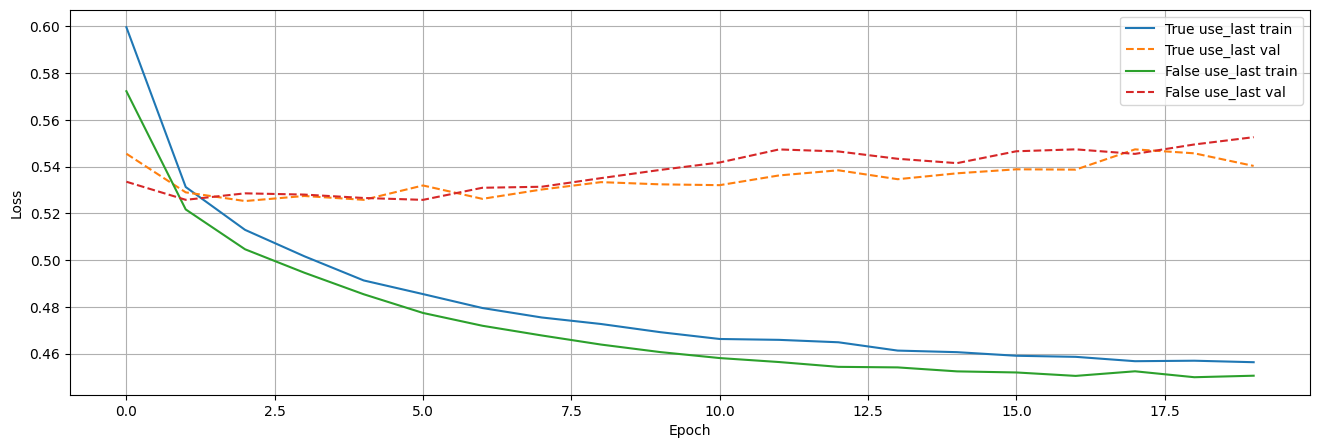

In [25]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

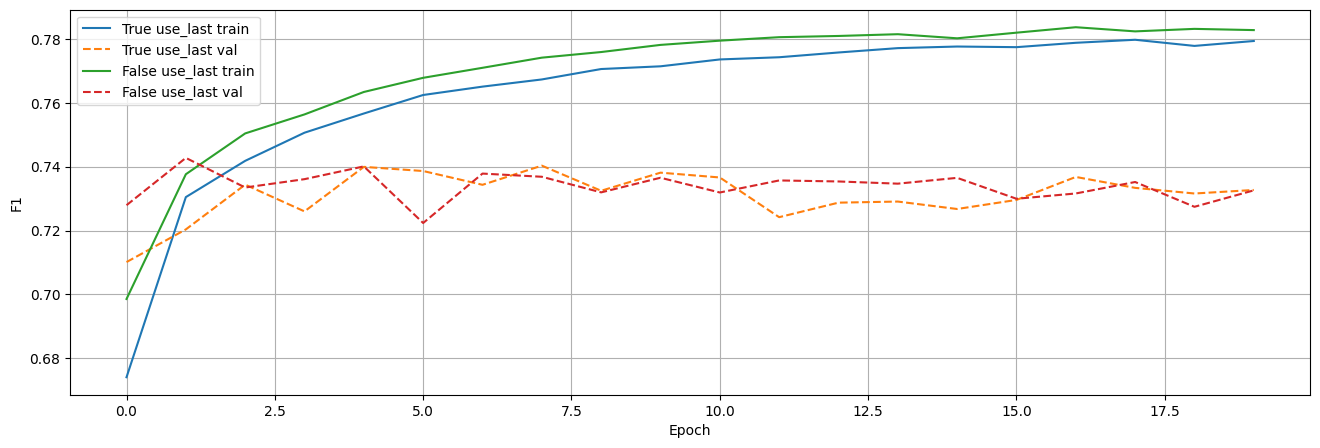

In [26]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

 В рекуррентных сетях важна длина последовательности.



